In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import warnings
from sklearn.svm import SVC, NuSVC, SVR
from scipy import stats
from constants import *
from auxiliary_functions import *
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, VotingClassifier, AdaBoostClassifier, BaggingRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from collections import namedtuple
from sklearn.decomposition import PCA
from os import cpu_count
from TwoGroupsWeightedModel import TwoGroupsWeightedModel
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import iqr, kurtosis, skew
from create_nqi_features_with_hand_direction_partition import create_nqi_features_from_raw_data_with_sides_partitions
from method1_feature_extraction import *
from plots import *
import random

### Configuration Constants

In [3]:
PROCESS_DATA_FILES = False  # if set to False, data will be loaded from saved files
CALCULATE_FEATURES = False
SHOW_PLOTS = True  # if true, plots will be printed in the quantiles filter section of the data


# Load Data

##Load full users and taps datasets from Kaggle

In [5]:
from KaggleDataLoader import *

if not PROCESS_DATA_FILES:
    kaggle_taps = pd.read_csv(KAGGLE_TAPS_INPUT)
    print("Kaggle taps dataframe:")
    print(kaggle_taps.head())
    kaggle_users = pd.read_csv(KAGGLE_USERS_INPUT)
    print("\nKaggle users dataframe:")
    print(kaggle_users.head())

else:
    # Create dataframe from files, perform basic cleaning
    kaggle_users = create_merged_users_details_file()
    print("\nKaggle users dataframe:")
    print(kaggle_users.head())
    
    kaggle_taps = create_merged_taps_dataframe()
    kaggle_taps = clean_bad_values(kaggle_taps)
    kaggle_taps = clean_incompatible_user_ids(kaggle_taps, kaggle_users)
    print("\nKaggle taps initial dataframe:")
    print(kaggle_taps.head())


Kaggle taps dataframe:
           ID  HoldTime  LatencyTime Hand  FlightTime Direction binIndex
0  0EA27ICBLF     101.6        234.4    L       156.3        LL  (0, 90]
1  0EA27ICBLF      85.9        437.5    L       359.4        LL  (0, 90]
2  0EA27ICBLF      78.1        210.9    L       125.0        LL  (0, 90]
3  0EA27ICBLF      62.5        359.4    L       281.3        LL  (0, 90]
4  0EA27ICBLF     125.0        187.5    S        93.8        LS  (0, 90]

Kaggle users dataframe:
   BirthYear     DA DiagnosisYear  Gender          ID  Impact  Levadopa  \
0     1952.0   True          2000  Female  0EA27ICBLF  Severe      True   
1     1959.0  False        ------  Female  0QAZFRHQHW  ------     False   
2     1946.0  False        ------  Female  0WTDIGPSBZ  ------     False   
3     1944.0  False        ------    Male  1HOEBIGASW  ------     False   
4     1953.0  False          2017    Male  1WMVCCU4RH  Medium     False   

    MAOB  Other  Parkinsons Sided  Tremors       UPDRS  
0  Fal

Filter outliers

In [5]:
if PROCESS_DATA_FILES:
    def filter_column_by_quantile(df, column, threshold):
        len_before = len(df)
        df = df[df[column] < np.percentile(df[column], threshold)]
        len_after = len(df)
        print("Filtered out {} rows with outliers in column '{}'".format((len_before - len_after), column))
        return df
    
    
    def plot_percentiles_of_column(df, col, start, end, bins):
        X = np.linspace(start, end, bins)
        Y = [np.percentile(df[col], x) for x in X]
        plt.plot(X, Y)
        plt.title(col + " Percentiles")
        plt.xlabel("Percent")
        plt.ylabel("Percentile Value")
        plt.show()
    
    
    # Filter out outliers of HoldTime:
    plot_percentiles_of_column(kaggle_taps, 'HoldTime', 99.96, 99.9999, 20)
    print("After the percentile 99.993 we see significantly higher values, which are definitely outliers.")
    kaggle_taps = filter_column_by_quantile(kaggle_taps, 'HoldTime', 99.993)


Divide keystroakes to time-intervals of 90 seconds:

In [8]:
if PROCESS_DATA_FILES:

    # Add parsed date and time column + calculate cumulative time
    kaggle_taps = add_cumulative_timestamps_column(kaggle_taps)
    
    # Group to bin indexes by the cumulative timestamps
    def build_bins(df, bin_size_seconds):
        df["PressTimeCumulative"] = df["PressTimeCumulative"] / 1000
        max_press = (int(max((df["PressTimeCumulative"])) / bin_size_seconds) + 1) * bin_size_seconds + 1
        user_bins = [i for i in range(0, max_press, bin_size_seconds)]
        df["binIndex"] = pd.cut((df["PressTimeCumulative"]), user_bins)
        return df
    
    
    kaggle_taps = build_bins(kaggle_taps, 90)
    
    # Keep only necessary columns and save to file
    kaggle_taps = kaggle_taps[TAPS_FINAL_COLUMNS + ['binIndex']]
    print("Kaggle taps final dataframe:")
    print(kaggle_taps.head())
    
    kaggle_taps.to_csv(constants.KAGGLE_TAPS_INPUT, index=False)

###Summary plots on Kaggle data

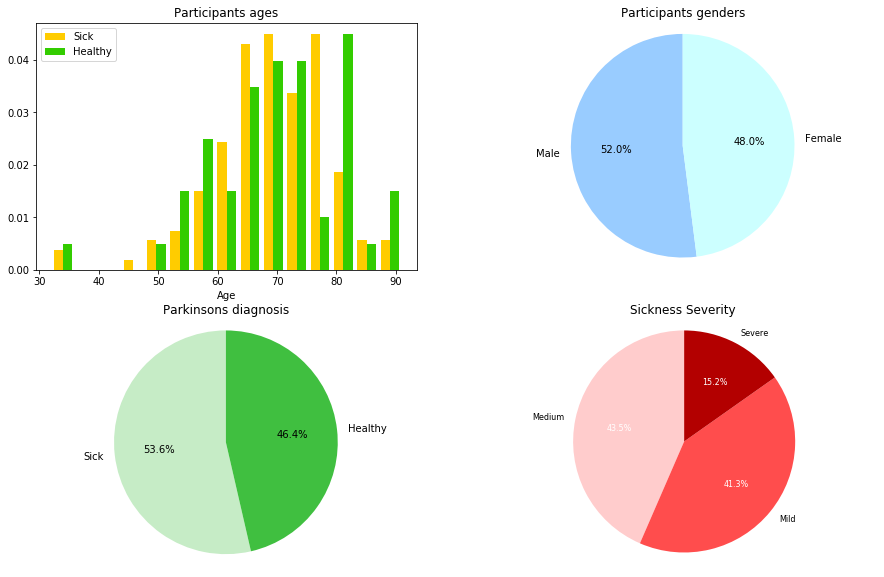

In [6]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

ages = add_age_column(kaggle_users)
mild_users = keep_only_mild_users(kaggle_users)

# general statistics of the users
fig = plt.figure(figsize=(15, 10))
ages_plot(fig, ages)
genders_plot(fig, mild_users)
diagnosis_plot(fig, mild_users)
sickness_level_plot(fig, ages)

warnings.resetwarnings()

####In-depth analysis of the values in 'HoldTime'
An important finding that we had during the analysis of the Kaggle data, is that there is a significant number of specific 'HoldTime' values that occur hundreds of thousands of times in the data, sometimes even in a series of sequential keystrokes, in a pattern that is totally unlikely.

10 most common values in 'HoldTime' and their count:
HoldTime
82.0     235253
117.2    260154
70.3     264541
125.0    304250
101.6    323205
85.9     339476
62.5     352945
109.4    387298
93.8     490810
78.1     645667
Name: HoldTime, dtype: int64


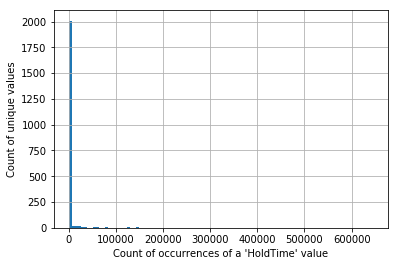

In [7]:
holdTimeCounters = kaggle_taps.groupby(['HoldTime']).HoldTime.count().sort_values()
print("10 most common values in 'HoldTime' and their count:")
print(holdTimeCounters.tail(10))
h = holdTimeCounters.hist(bins=100).set(xlabel="Count of occurrences of a 'HoldTime' value", ylabel="Count of unique values")

We can see that most of the values appear less than 200 times, while there are some extreme values that appear hundred of thousand of time.

As an example, let's focus on the extreme value '78.1'. If it was a valid normal value, we would expect to see that the density of it's appearance count should be similar to those of values around it. Let's plot the histogram around the value '78.1': 

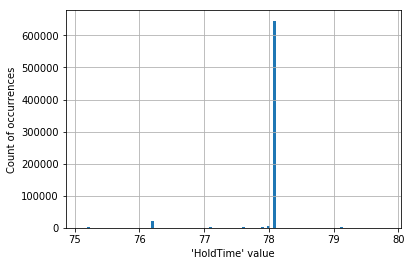

In [9]:
hist = kaggle_taps[(kaggle_taps.HoldTime < 80) & (kaggle_taps.HoldTime > 75)].HoldTime \
    .hist(bins=100).set(xlabel="'HoldTime' value", ylabel="Count of occurrences")

We can see that the value is '78.1' is extremely common (>600,000 occurrences) while other close values are rare.
We therefore conclude that the Kaggle data has built-in corrupted entries which are hard to distinguish from the correct ones. Trying to filter out such extremely common values leads to losing the vast majority of tha data. We therefore decided to continue working with the original data but keeping in mind the understanding that the signal could be corrupted.

##Load full users and taps datasets from MIT dataset

In [11]:
from MITDataLoader import *

if not PROCESS_DATA_FILES:
    mit_taps = pd.read_csv(MIT_TAPS_INPUT)
    print("MIT taps dataframe:")
    print(mit_taps.head())
    mit_users = pd.read_csv(MIT_USERS_INPUT)
    print("\nMIT users dataframe:")
    print(mit_users.head())

else:
    mit_users = pd.read_csv(USERS, delimiter=',', header=0, error_bad_lines=False,
                            low_memory=False, usecols=["pID", "gt", "updrs108", "file_1", "file_2"])
    
    mit_taps = create_merged_taps_dataframe()
    print("\nMIT taps initial dataframe:")
    print(mit_taps.head())
    mit_taps = clean_errors_and_bad_values(mit_taps)
    

MIT taps dataframe:
   ID Hand Direction  HoldTime  LatencyTime  FlightTime  pressTime binIndex
0  68    L        RL     133.7        590.4       471.0     2.4218  (0, 90]
1  68    L        LL     184.7        473.1       339.4     2.8949  (0, 90]
2  68    L        LL     149.9        346.4       161.7     3.2413  (0, 90]
3  68    R        LR     213.7        720.3       570.4     3.9616  (0, 90]
4  68    R        RR     164.3       2505.7      2291.9     6.4673  (0, 90]

MIT users dataframe:
   ID  Parkinsons  UPDRS
0  11        True  14.25
1  60       False   2.00
2  67        True  25.25
3  68       False   6.00
4  70        True  26.25


Divide keystroakes to time-intervals of 90 seconds:

In [12]:
if PROCESS_DATA_FILES:

    # Group to bin indexes by pressTime and add as a new column
    bin_size_seconds = 90
    max_press = (int(max(mit_taps["pressTime"]) / bin_size_seconds) + 1) * bin_size_seconds + 1
    user_bins = [i for i in range(0, max_press, bin_size_seconds)]
    mit_taps["binIndex"] = pd.cut(mit_taps["pressTime"], user_bins)


Filter outliers:

In [13]:
if PROCESS_DATA_FILES:
    
    def plot_percentile(df, column, start, end, bins):
        X = np.linspace(start, end, bins)
        Y = [np.percentile(df[column], x) for x in X]
        plt.plot(X, Y)
        plt.title(column + " Percentiles")
        plt.xlabel("Percent")
        plt.ylabel("Percentile Value")
        plt.show()
    
    
    def filter_column_by_quantile(df, column, threshold):
        len_before = len(df)
        df = df[df[column] < np.percentile(df[column], threshold)]
        len_after = len(df)
        print("Filtered out {} rows with outliers in column '{}'".format((len_before - len_after), column))
        return df
    
    
    if SHOW_PLOTS:
        for col in list(set(FLOAT_COLUMNS) - {"pressTime"}):
            plot_percentile(mit_taps, col, 98, 99.9999, 40)
    
    # Filter according to the results in the plots
    mit_taps = filter_column_by_quantile(mit_taps, "HoldTime", 99.99)
    mit_taps = filter_column_by_quantile(mit_taps, "LatencyTime", 99.4)
    mit_taps = filter_column_by_quantile(mit_taps, "FlightTime", 99.95)


Save final dataframe:

In [15]:
if PROCESS_DATA_FILES:

    # Save to file - Taps file
    mit_taps[["HoldTime", "LatencyTime", "FlightTime"]] = \
        1000 * mit_taps[["HoldTime", "LatencyTime", "FlightTime"]]  # to milliseconds
    print("MIT taps final dataframe:")
    print(mit_taps.head())
    
    mit_taps.to_csv(MIT_TAPS_INPUT, index=False)
    
    # Save to file - Users file
    mit_users.rename(columns={'pID': 'ID', 'gt': 'Parkinsons', 'updrs108': 'UPDRS'}, inplace=True)
    mit_users = mit_users[['ID', 'Parkinsons', 'UPDRS']]
    print("MIT users dataframe:")
    print(mit_users.head())
    
    mit_users.to_csv(MIT_USERS_INPUT, index=False)

Summary plots on MIT data:

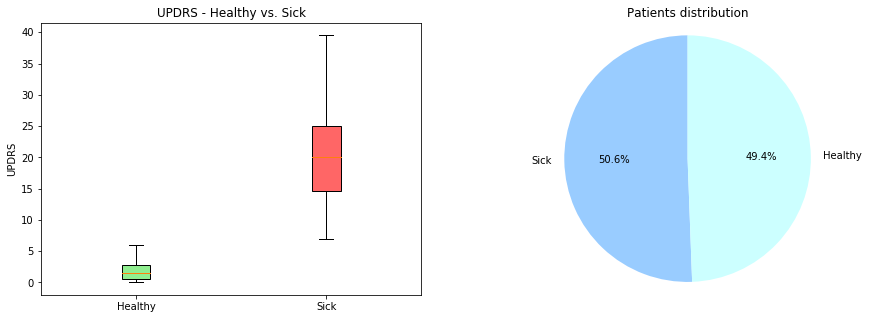

In [16]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

fig = plt.figure(figsize=(15, 5))
mit_updrs_distribution(fig, mit_users)
mit_diagnosis(fig, mit_users)

warnings.resetwarnings()

#Feature Creation

##1. Creating features from the Kaggle data set, according to the first approach:

For every patient, calculate summary statistics for all of their data, partitioned into Left/Right, and LR/RL/LL/RR transitions: 


In [20]:
if CALCULATE_FEATURES:
    method1_features = create_summary_statistics(kaggle_taps,
                                                 columns_to_aggregate=["FlightTime", "HoldTime", "LatencyTime"],
                                                 aggregation_functions=[np.mean, np.std, stats.kurtosis, stats.skew,
                                                            stats.entropy, percnt10, percnt20, percnt40, percnt60, percnt70,
                                                            percnt80, percnt90])
    # Add a feature of the mean-diff between Left and Right HoldTimes, and Between LR and RL LatencyTimes:
    method1_features["mean_diff_L_R_HoldTime"] = method1_features.R_HoldTime_mean - method1_features.L_HoldTime_mean
    method1_features["mean_diff_LR_RL_LatencyTime"] = method1_features.RL_LatencyTime_mean - method1_features.LR_LatencyTime_mean
    method1_features["mean_diff_LL_RR_LatencyTime"] = method1_features.LL_LatencyTime_mean - method1_features.RR_LatencyTime_mean
    
    # Join with the Users data:
    method1_features = method1_features.merge(kaggle_users, on="ID", how="left")
    # Dump to csv:
    method1_features.to_csv(KAGGLE_DATA_ARTICLE_METHOD1_FEATURES)
else:
    method1_features = pd.read_csv(KAGGLE_DATA_ARTICLE_METHOD1_FEATURES)
    
print("Summary statistics on the Kaggle data:\n\n",method1_features.head())

Summary statistics on the Kaggle data:

    Unnamed: 0          ID  L_FlightTime_mean  L_FlightTime_std  \
0           0  0EA27ICBLF         239.655394        107.822976   
1           1  0QAZFRHQHW         319.277429        162.896291   
2           2  1HOEBIGASW         386.722581        175.209404   
3           3  1XNJCXS3EY         226.013786         85.352172   
4           4  2JTCBKUP8T         265.411441        160.215877   

   L_FlightTime_kurtosis  L_FlightTime_skew  L_FlightTime_entropy  \
0              -1.263192          -0.032858             11.148338   
1              -0.659685           0.361020              6.322468   
2              -0.927794          -0.326568              3.319654   
3              -0.493719          -0.125464              6.045913   
4              -0.093353           0.540118              8.959632   

   L_FlightTime_percnt10  L_FlightTime_percnt20  L_FlightTime_percnt40  \
0                   93.8                  125.0                 203.10   

Filter the data so that we only keep patients with plenty of tapping events, and only patients with mild Parkinsons:

In [22]:
method1_features = method1_features[method1_features.total_count >= TAPS_THRESHOLD]  # take only users with more than THRESHOLD keystrokes
method1_features = method1_features[method1_features.Levadopa.astype(str) == 'False']
method1_features = method1_features[(method1_features.Parkinsons.astype(str) == 'False') | ( (method1_features.Parkinsons.astype(str) == 'True') & (method1_features.Impact == "Mild"))]



### Summary plots of Kaggle data features
For example, following are the plots of the features of the Left side FlightTime data:

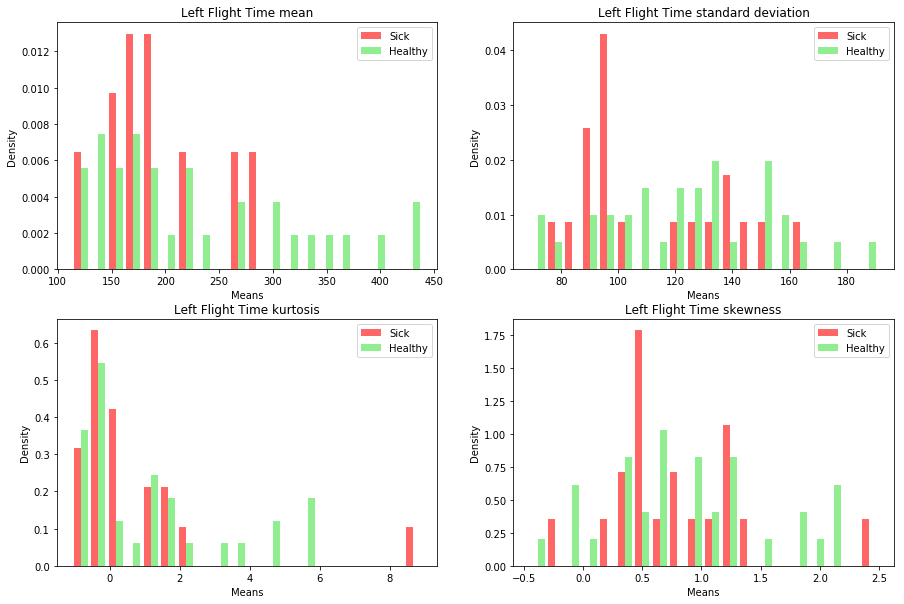

In [23]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

sick = method1_features.loc[(method1_features['Parkinsons'] == True)]
healthy = method1_features.loc[(method1_features['Parkinsons'] == False)]

fig = plt.figure(figsize=(15, 10))
lFlight_mean(fig, sick, healthy)
lFlight_std(fig, sick, healthy)
lFlight_kurtosis(fig, sick, healthy)
lFlight_skew(fig, sick, healthy)

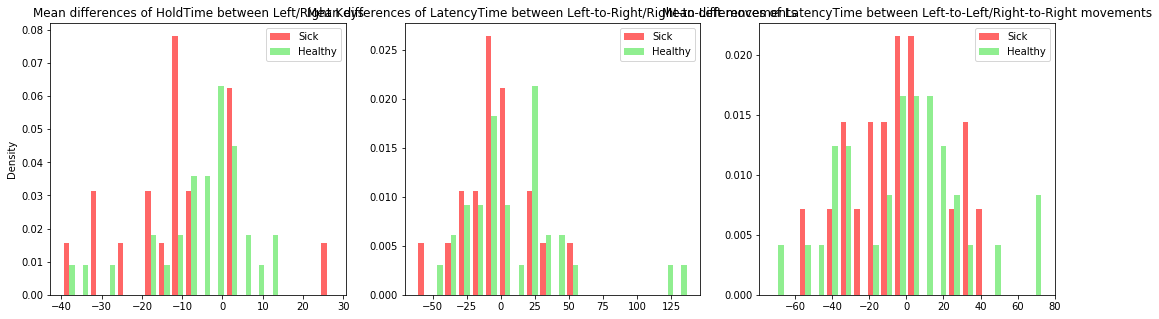

In [24]:
fig = plt.figure(figsize=(18, 5))

LR_Hold_Time(fig, healthy, sick)
LR_RL_Latency_Time(fig, healthy, sick)
LL_RR_Latency_Time(fig, healthy, sick)

warnings.resetwarnings()

#Modeling Phase 1: Attempting to reproduce the results from the Kaggle challenge article

In [25]:
# The summary statistics used in the original article:
ARTICLE_EXPLANATORY_VARIABLES =['L_HoldTime_mean', 'L_HoldTime_std', 'L_HoldTime_kurtosis', 'L_HoldTime_skew',
 'R_HoldTime_mean', 'R_HoldTime_std', 'R_HoldTime_kurtosis', 'R_HoldTime_skew', 'LL_LatencyTime_mean', 'LL_LatencyTime_std',
 'LL_LatencyTime_kurtosis', 'LL_LatencyTime_skew', 'LR_LatencyTime_mean', 'LR_LatencyTime_std', 'LR_LatencyTime_kurtosis',
 'LR_LatencyTime_skew', 'RL_LatencyTime_mean', 'RL_LatencyTime_std', 'RL_LatencyTime_kurtosis', 'RL_LatencyTime_skew',
 'RR_LatencyTime_mean', 'RR_LatencyTime_std', 'RR_LatencyTime_kurtosis', 'RR_LatencyTime_skew', 'mean_diff_LR_RL_LatencyTime',
 'mean_diff_LL_RR_LatencyTime', 'mean_diff_L_R_HoldTime']




### First attempt: applying several models to the raw data with the variables used in the article, without further processing:


In [138]:
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES]
y = method1_features["Parkinsons"]
classifiers = [LogisticRegression(),
               RandomForestClassifier(),
               AdaBoostClassifier(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(),
               SVC(kernel='rbf', probability=True),
               ]
for final_classifier in classifiers:
    accuracy = evaluate_classifier_cv(final_classifier, X, y, cross_validation_folds=5)
    print(str(final_classifier).split("(")[0] + ":")
    print("\t"+accuracy.train)
    print("\t" + accuracy.test)

LogisticRegression:
	Train accuracy:0.7885
	Test accuracy (5-fold cross validation):0.5218
RandomForestClassifier:
	Train accuracy:0.9808
	Test accuracy (5-fold cross validation):0.5945


AdaBoostClassifier:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.6545
KNeighborsClassifier:
	Train accuracy:0.6538
	Test accuracy (5-fold cross validation):0.52


GradientBoostingClassifier:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.5509
SVC:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.6327


we can see that all models are highly overfitted, and do not perform well.

### Second attempt: normalize the data and apply PCA dimensionality reduction

In [27]:
scaler = StandardScaler()
normalized_X = scaler.fit_transform(X)

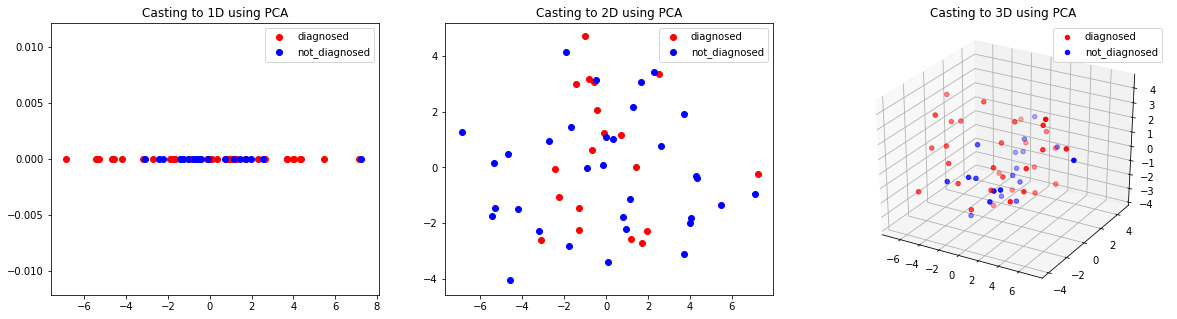

In [28]:
# Visualizing the data in 3d, 2d and 1d after PCA:

pca = PCA(n_components=1)
reduced_X = pca.fit_transform(normalized_X)
_1d_res = get_labeled_data_1d(reduced_X, y)

pca = PCA(n_components=2)
reduced_X = pca.fit_transform(normalized_X)
_2d_res = get_labeled_data_2d(reduced_X, y)

pca = PCA(n_components=3)
reduced_X = pca.fit_transform(normalized_X)
_3d_res = get_labeled_data_3d(reduced_X, y)

plot_dimensionality_reduction(_1d_res, _2d_res, _3d_res)

From the above plots, it is evident that the data is not well seperated in low dimensions. We now try all possible dimensionality reductions, and for every number of dimensions we reduce to, we apply several classification models and keep the test score of the best one:

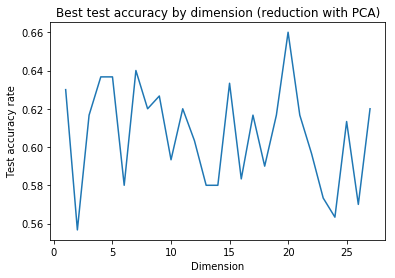

In [142]:
original_dim = len(normalized_X[0])
tested_dimensions = []
accuracies = []
for dim in [i for i in range(1, original_dim+1)]:
    if dim != original_dim:
        pca = PCA(n_components=dim)
        reduced_X = pca.fit_transform(normalized_X, y.values)
    else:
        reduced_X = normalized_X
    best_accuracy = namedtuple("best_accuracy", "clf_name test_accuracy train_accuracy")
    best_accuracy.test_accuracy = -1  #init
    for clf in classifiers:
        accuracy = evaluate_classifier_cv(clf, reduced_X, y, cross_validation_folds=10)
        if accuracy.test_score > best_accuracy.test_accuracy:
            best_accuracy.test_accuracy = accuracy.test_score
            best_accuracy.clf_name = str(clf).split("(")[0]
    tested_dimensions.append(dim)
    accuracies.append(best_accuracy.test_accuracy)
plt.title("Best test accuracy by dimension (reduction with PCA)")
plt.xlabel("Dimension")
plt.ylabel("Test accuracy rate")
p = plt.plot(tested_dimensions, accuracies)


We can see that PCA dimensionality reduction does not improve performance.

We now apply LDA dimensionality reduction and scaling to the data, and randomly split to test and train sets. Results here have high variance due to the small size of the dataset, so we repeat the process 100 times and average the results:

In [144]:
# LDA produces a "Variables are collinear" warning here. This is true, 
# as the Pearson Correlation factor of some of the features is very close to one. As we now attempt to reproduce the results of the article,
# we will ignore this error.
res = pd.DataFrame()
for i in range(100):
    warnings.filterwarnings("ignore", category=UserWarning)
    train_X, train_y, test_X, test_y = split_to_train_test_and_apply_scaling_and_lda_dim_reduction(X, y, 
                                                                                                   train_percentage=0.7)
    warnings.resetwarnings()
    
    # Fit several models, and find the best one by AUC measure:
    best_auc, best_clf = get_best_roc(classifiers, train_X, train_y, test_X, test_y)
    res = res.append([{'model': type(best_clf).__name__, 'score':best_auc}])
mean_values = res.groupby("model")["score"].mean()
print("Best AUC and model:\n\n", mean_values[mean_values == mean_values.max()])

Best AUC and model:
 model
GradientBoostingClassifier    0.582645
Name: score, dtype: float64


It is evident that neither technique of dimensionaliy reduction improves performance. 
We now explore adding additional predictors, specifically calculating percentles of the HoldTime and LatencyTime, trying to better describe the distribution of these measures for each patient. Results here have high variance due to the small size of the dataset, so we repeat the process 100 times and average the results:

In [189]:
PERCENTILES = [c for c in method1_features.columns.values if "perc" in c and "FlightTime" not in c]
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES + PERCENTILES]
y = method1_features["Parkinsons"]

# LDA produces a "Variables are collinear" warning here. This is true, 
# as the Pearson Correlation factor of some of the features is very close to one. As we now attempt to reproduce the results of the article,
# we will ignore this error.

res = pd.DataFrame()
for i in range(100):
    warnings.filterwarnings("ignore", category=UserWarning)
    train_X, train_y, test_X, test_y = split_to_train_test_and_apply_scaling_and_lda_dim_reduction(X, y, 
                                                                                                   train_percentage=0.7)
    warnings.resetwarnings()
    
    # Fit several models, and find the best one by AUC measure:
    best_auc, best_clf = get_best_roc(classifiers, train_X, train_y, test_X, test_y)
    res = res.append([{'model': type(best_clf).__name__, 'score':best_auc}])
mean_values = res.groupby("model")["score"].mean()
print("Best AUC and model:\n\n", mean_values[mean_values == mean_values.max()])

Best AUC and model:

 model
SVC    0.6143
Name: score, dtype: float64


model
LogisticRegression    0.649838
Name: score, dtype: float64

We now continue to follow the method descdribed in the article, by partitioning the data into two groups, Hold variables and Latency variables (depending on the orignal column they were created by). 
We then assign a Parkinson's probability using each group seperately, and output a final probability as a weighted average of these two probabilities.

In [145]:
from TwoGroupsWeightedModel import TwoGroupsWeightedModel
import warnings

ALL_VARIABLES = ARTICLE_EXPLANATORY_VARIABLES
HOLD_VARIABLES = [v for v in ALL_VARIABLES if "HoldTime" in v]
LATENCY_VARIABLES = [v for v in ALL_VARIABLES if "LatencyTime" in v]

voting_ensemble = VotingClassifier(estimators=[
                                    ('1', RandomForestClassifier()),
                                    ('2', SVC(probability=True)),
                                    ('3', MLPClassifier()),
                                    ('4', LogisticRegression()),
                                    ('5', NuSVC(probability=True)),
                                    ('6', KNeighborsClassifier()),
                                    ('7', DecisionTreeClassifier()),
                                    ('8', QuadraticDiscriminantAnalysis())
                                  ],
                        voting='soft')


def weighting_function(hold_probs, latency_probs):
    """
    These are the weights described in the article. We note that this weighting can yield probs > 1, and therefore is not optimal. 
    We've tried other weightings as well, with no significant improvement.
    """
    return (hold_probs + 0.5*(1-1.2) + 1.2*latency_probs)/2.0


groups_model = TwoGroupsWeightedModel(underlying_estimator_module_and_class="sklearn.pipeline Pipeline",
                            group1_var_names=HOLD_VARIABLES,
                            group2_var_names=LATENCY_VARIABLES,
                             weighting_function=weighting_function,              
                            classification_threshold=0.5,
                            steps=[("normalization", StandardScaler()),
                                   ("lda", LinearDiscriminantAnalysis()),
                                   ("clf", voting_ensemble)])

# calculate accuracy and AUC for the groups-model, using K-fold CV:
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES]
y = method1_features["Parkinsons"]

"""
Training the model on this data results in a "Collinear Variables" warnings. This is true, as some of the variables have very high Pearson-correlation.
In order to reporoduce the article findings we ignore these erros for now, and  filter warnings for the next few lines. 
"""
warnings.filterwarnings("ignore")
test_auc = evaluate_classifier_cv(clf=groups_model, X=X, y=y, cross_validation_folds=5, scoring='roc_auc').test_score
test_accuracy = evaluate_classifier_cv(clf=groups_model, X=X, y=y, cross_validation_folds=5, scoring='accuracy').test_score
warnings.resetwarnings()

print("Test AUC: {}\nTest Accuracy: {}".format(test_auc, test_accuracy))

Test AUC: 0.4230952380952381
Test Accuracy: 0.5163636363636364


Conclusion: in the above section we tried to reproduce and improve the classifying technique described in the article that inspired the Kaggle challenge. 
We believe that the the results in the aticle are not valid and non-reproducible, and we ellaborate further on this in the project document.

#Modeling Phase 2: A completely different approach, inspired by results published by a team of MIT researchers

We first construct the features for the UPDRS-regression:

In [146]:
from nqi_feature_creation_functions import *
MIN_PRESSES_PER_BUCKET_THRESHOLD = 1 # Filtering on a higher value did not prove usefull

# Create the NQI features for both the MIT and the Kaggle Datasets:
i = 1
if CALCULATE_FEATURES:
    for taps_input_file_path, nqi_features_output_filepath in \
            zip([MIT_TAPS_INPUT, KAGGLE_TAPS_INPUT], [MIT_NQI_FEATURES, KAGGLE_NQI_FEATURES]):
        print("Creating features for dataset #{}...".format(i))
        taps = pd.read_csv(taps_input_file_path)
        len_before = len(taps)
        taps = taps.groupby(["ID", "binIndex"]).filter(lambda x: x['HoldTime'].count() > MIN_PRESSES_PER_BUCKET_THRESHOLD)
        print("\tRemoved {} rows from time-windows containing too few taps in file.".format(len_before - len(taps)))
        
        # Filter out time-windows where the IQR feature cannot be calculated (this happens in the Kaggle data set,
        # due to sparse time windows and HoltTime values that are very common. See project documentation for elaboration on this issue.)
        len_before = len(taps)
        taps = taps.groupby(['ID','binIndex']).filter(lambda x: np.percentile(x.HoldTime, 25) != np.percentile(x.HoldTime, 75) )
        print("\tFiltered {} rows where the IQR feature cannot be calculated.".format(len_before - len(taps)))
        
        grouped_taps = taps.groupby(["ID", "binIndex"])["HoldTime"].agg([agg_outliers, agg_iqr, agg_histogram_bin0, agg_histogram_bin1,
                                                            agg_histogram_bin2, agg_histogram_bin3, np.count_nonzero])
        t = taps.groupby(["ID", "binIndex"])["FlightTime"].agg([np.mean, np.std]).reset_index()
        nqi_calculator_input = grouped_taps.reset_index()
        nqi_calculator_input = nqi_calculator_input.merge(t, on=["ID","binIndex"])
        nqi_calculator_input = nqi_calculator_input.rename(columns={"FlightTime": "mean_flight"})
    
        nqi_calculator_input = nqi_calculator_input[nqi_calculator_input.count_nonzero > MIN_PRESSES_PER_BUCKET_THRESHOLD]
    
        nqi_calculator_input.to_csv(nqi_features_output_filepath, index=False)
        print("\tDone.")
        i += 1

In [162]:
mit_nqi_features = pd.read_csv(MIT_NQI_FEATURES)
mit_users = pd.read_csv(MIT_USERS_INPUT)


print("Regression features on the MIT dataset:\n\n", mit_nqi_features.head())

mit_data = mit_nqi_features.merge(mit_users, on="ID").dropna().reset_index().drop("index", axis=1)
PREDICTION_COLUMNS = list_diff(mit_data.columns, ["UPDRS", "Parkinsons", 'binIndex', 'ID', 'count_nonzero'])

# Split the unified MIT dataset to train and test according to ID's:
train_mit_data = mit_data[mit_data.ID <= 100].copy()
test_mit_data = mit_data[mit_data.ID >= 1000].copy()

Regression features on the MIT dataset:

    ID    binIndex  agg_outliers   agg_iqr  agg_histogram_bin0  \
0  11     (0, 90]      0.018868  0.275847            0.005585   
1  11  (180, 270]      0.018141  0.318952            0.005170   
2  11  (270, 360]      0.027888  0.330284            0.005689   
3  11  (360, 450]      0.028205  0.254762            0.005682   
4  11  (450, 540]      0.011472  0.273350            0.005629   

   agg_histogram_bin1  agg_histogram_bin2  agg_histogram_bin3  count_nonzero  \
0            0.002340            0.000075            0.000000          530.0   
1            0.002739            0.000054            0.000036          441.0   
2            0.002279            0.000032            0.000000          502.0   
3            0.002297            0.000021            0.000000          390.0   
4            0.002325            0.000046            0.000000          523.0   

         mean         std  
0  178.038113  173.574397  
1  182.795918  226.183604  
2 

### Summary plots of MIT data features

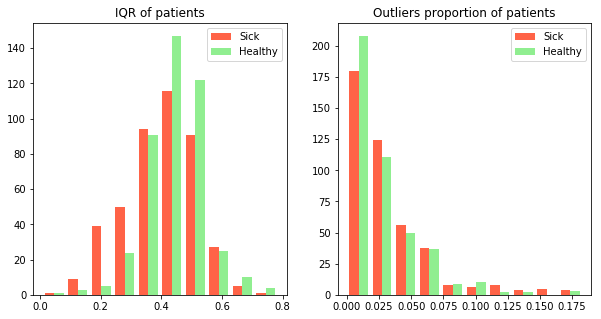

In [163]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

fig = plt.figure(figsize=(10,5))
iqr_histogram(fig, mit_data)
outliers_histogram(fig, mit_data)

warnings.resetwarnings()

### Construct a regression model to predict UPDRS score and then classify patients accordingly:

In [179]:
# We first define a function that performs the UPDRS-regression and subsequent classification using the regression's predictions:

def nqi_regression_and_pd_classification(train_data, test_data, regression_model, final_classifier, prediction_columns):
    """
    :param train_data, test_data: a DataFrame with NQI-features and regression target ('UPDRS').
    :param regression_model: the regression model that will be used for predicting the nqi score.
    :param final_classifier: the classification model that will be used for predicting Parkinson's/no-Parkinson's based on the predicted nqi score.
    :return: the test AUC of the final model, that uses the predicted-nqi in order to predict Parkinson's.
    """
    scaler = StandardScaler()
    min_max_scaler = MinMaxScaler(feature_range=(0, 1))  # We use this to scale the UPDRS target to the [0,1] interval.
    
    train_X = train_data[prediction_columns]
    train_y = train_data["UPDRS"]
    
    train_X = pd.DataFrame(scaler.fit_transform(train_X))
    train_y = min_max_scaler.fit_transform(train_y.values.reshape(-1,1))
    
    test_X = test_data[prediction_columns]
    test_X = pd.DataFrame(scaler.transform(test_X))
    regression_model.fit(X=train_X, y=np.ravel(train_y))

    train_nqi_predictions = regression_model.predict(train_X)
    train_data["predicted_nqi"] = train_nqi_predictions
    # calculate the average predicted-nqi per training patient:
    train_final_df = train_data.groupby("ID")["Parkinsons", "predicted_nqi"].mean().reset_index()

    # predict nqi for every subject in the test-set (as mean of predicted nqi of all the subject's time-windows):
    test_nqi_predictions = regression_model.predict(test_X)
    test_data["predicted_nqi"] = test_nqi_predictions
    test_final_df = test_data.groupby("ID")["Parkinsons", "predicted_nqi"].mean().reset_index()

    # Use the result of the nqi-regression, to predict Parkinsons. To do so, we use another classification model (different models yield similar ersults):
    
    final_classifier.fit(train_final_df["predicted_nqi"].values.reshape(-1, 1), train_final_df["Parkinsons"])

    predicted_test_probs = final_classifier.predict_proba(test_final_df["predicted_nqi"].values.reshape(-1, 1))[:, 1]
    test_set_auc = roc_auc_score(y_true=test_final_df["Parkinsons"], y_score=predicted_test_probs)
    result = namedtuple('result', 'test_auc y_true y_predicted')
    result.test_auc, result.y_true, result.y_predicted  = test_set_auc, test_final_df["Parkinsons"], predicted_test_probs
    
    return result 

We now apply the UPDRS-regression procedure using a bagging-ensemble of 200 support-vector regressors, in accordance with the original research. We then use logistic regression as the final classifier (Our tests show that most classification models yield very similar results). 

In [180]:
sv_regression_ensemble = BaggingRegressor(base_estimator=SVR(),
                                n_estimators=200,
                                bootstrap=True,
                                n_jobs=1)

nqi_regression_on_mit_data_with_sv_regression_results = nqi_regression_and_pd_classification(train_mit_data, test_mit_data,
                                                regression_model=sv_regression_ensemble,
                                                final_classifier=LogisticRegression(), prediction_columns=PREDICTION_COLUMNS
                                                )
test_auc = nqi_regression_on_mit_data_with_sv_regression_results.test_auc
print("Test AUC using support-vector regression: {}".format(test_auc))

Test AUC using support-vector regression: 0.7444444444444444


We can see that the above method works well, providing similar results to those described in the article (our result lie within the CI of the AUC achieved in the Nature article).
We've tested some other approaches, and found the following to be more effective - we use a large forest of boosted regression trees instead of the support-vector regression ensemble:

In [181]:
gbt_regression_ensemble = GradientBoostingRegressor(n_estimators=1000)

nqi_regression_on_mit_data_with_gbt_regression_results = nqi_regression_and_pd_classification(train_mit_data, test_mit_data,
                                                regression_model=gbt_regression_ensemble,
                                                final_classifier=LogisticRegression(), prediction_columns=PREDICTION_COLUMNS
                                                )
print("Test AUC using gb-tree regression: {}".format(nqi_regression_on_mit_data_with_gbt_regression_results.test_auc))

Test AUC using gb-tree regression: 0.8416666666666667


Plot the predicted NQI scores of the MIT data, separated to PD-positive and PD-negative patients

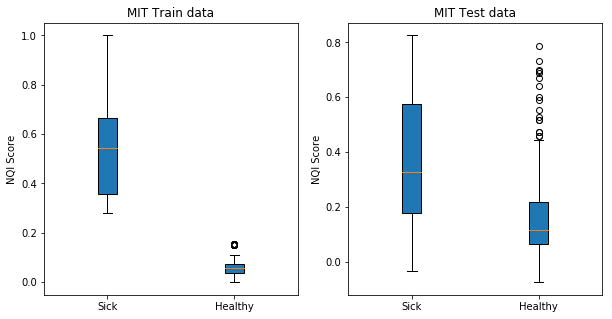

In [182]:
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore pandas warning caused by an internal call to deprecated 'reshape'

fig = plt.figure(figsize=(10,5))
boxplot_nqi_score(fig, 1, train_mit_data, "MIT Train data")
boxplot_nqi_score(fig, 2, test_mit_data, "MIT Test data")

warnings.resetwarnings()

We can see that even on the test data, there is a significant difference between the distibution of the NQI scores of healthy and sick patients.
Therefore, we can now try to predict whether a patient is healthy or sick based on their score.

# Optimize regressor parameters:

In [168]:
train_X = train_mit_data[PREDICTION_COLUMNS]
train_y = train_mit_data["UPDRS"]

param_space = {
    'n_estimators': [100,500,1000],
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': [0.001,0.01,0.1],
    'max_depth': [1,2,3,5,7,8],
    'max_leaf_nodes': [None, 3, 5, 10, 50, 100]
}

grid_searcher = GridSearchCV(gbt_regression_ensemble, param_grid=param_space, n_jobs=-1, cv=3, verbose=2, scoring="r2")
grid_searcher.fit(X=train_X, y=np.ravel(train_y))
print("Best params:\n", grid_searcher.best_params_)


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


KeyboardInterrupt: 

Calculate AUC with optimized parameters:

In [222]:
gbt_regression_ensemble.set_params(**grid_searcher.best_params_)

nqi_regression_on_mit_data_with_optimized_gbt_regression_results = nqi_regression_and_pd_classification(train_mit_data, test_mit_data,
                                                regression_model=gbt_regression_ensemble,
                                                final_classifier=LogisticRegression(), prediction_columns=PREDICTION_COLUMNS
                                                )
print("Test AUC using gb-tree regression after hyper-parameter optimization: {}".format(nqi_regression_on_mit_data_with_optimized_gbt_regression_results.test_auc))


NameError: name 'grid_searcher' is not defined

We will now try to evaluate the relevance of the above method to home-environment data, by training the nqi-regression model on all of the MIT data, and testing it on the Kaggle data (which is home-environment data):

In [183]:
kaggle_nqi_features = pd.read_csv(KAGGLE_NQI_FEATURES)
kaggle_users_data = pd.read_csv(KAGGLE_USERS_INPUT)
kaggle_data = kaggle_nqi_features.merge(kaggle_users_data, on="ID").dropna().reset_index().drop(["index"], axis=1)

# Remove patients taking Levadopa or patients with non-mild Parkinson's:
kaggle_data = kaggle_data[kaggle_data.Levadopa == False]
kaggle_data = kaggle_data[kaggle_data.Parkinsons == False | ((kaggle_data.Parkinsons == True) & (kaggle_data.Impact == "Mild"))]


# Apply nqi-regression:
nqi_regression_on_kaggle_and_mit_data_with_gbt_regression_results = nqi_regression_and_pd_classification(train_data=mit_data, test_data=kaggle_data, 
                                     regression_model=gbt_regression_ensemble, 
                                     final_classifier=LogisticRegression(), prediction_columns=PREDICTION_COLUMNS)
print("Test AUC on Kaggle data training on MIT data: {}".format(nqi_regression_on_kaggle_and_mit_data_with_gbt_regression_results.test_auc))

Test AUC on Kaggle data training on MIT data: 0.47084548104956264


We see above that the UPDRS-regression trained on the MIT data does not generalize well to the Kaggle data. We propose two possible explanations for this: it could be that the MIT data is fundamentally different, being collected in the lab and not at home. Another possible explanation is that the Kaggle data is corrupt (this could explain the inability to reproduce the first article).

Our next step is to apply the main idea from the first article, i.e splitting the keystroaks according to the side of the keyboard in which the occure, to the MIT data using the features constructed above for UPDRS regression:

In [184]:
# Preparing the MIT data with measures of assymetry:
nqi_features_with_side_partitions_data_path = create_nqi_features_from_raw_data_with_sides_partitions(MIT_TAPS_INPUT, MIT_NQI_FEATURES_SIDES_PARTITIONS)

mit_nqi_features_with_sides_partition = pd.read_csv(nqi_features_with_side_partitions_data_path)
mit_users = pd.read_csv(MIT_USERS_INPUT)

print("NQI features with keyboard side partitions:\n")
print(sorted(mit_nqi_features_with_sides_partition.columns))

mit_data_with_sides_partition = mit_nqi_features_with_sides_partition.merge(mit_users, on="ID").dropna().reset_index().drop("index", axis=1)
PREDICTION_COLUMNS_SIDE_PARTITION = list_diff(mit_data_with_sides_partition.columns, ["UPDRS", "Parkinsons", 'binIndex', 'ID', 'count_nonzero'])

# Split the unified MIT dataset to train and test according to ID's:
train_mit_data_with_sides_partitions = mit_data_with_sides_partition[mit_data_with_sides_partition.ID <= 100].copy()
test_mit_data_with_sides_partitions = mit_data_with_sides_partition[mit_data_with_sides_partition.ID >= 1000].copy()

NQI features with keyboard side partitions:

['ID', 'LL_agg_histogram_bin0', 'LL_agg_histogram_bin1', 'LL_agg_histogram_bin2', 'LL_agg_histogram_bin3', 'LL_agg_iqr', 'LL_agg_outliers', 'LL_std', 'LR_agg_histogram_bin0', 'LR_agg_histogram_bin1', 'LR_agg_histogram_bin2', 'LR_agg_histogram_bin3', 'LR_agg_iqr', 'LR_agg_outliers', 'LR_std', 'L_agg_histogram_bin0', 'L_agg_histogram_bin1', 'L_agg_histogram_bin2', 'L_agg_histogram_bin3', 'L_agg_iqr', 'L_agg_outliers', 'L_std', 'RL_agg_histogram_bin0', 'RL_agg_histogram_bin1', 'RL_agg_histogram_bin2', 'RL_agg_histogram_bin3', 'RL_agg_iqr', 'RL_agg_outliers', 'RL_std', 'RR_agg_histogram_bin0', 'RR_agg_histogram_bin1', 'RR_agg_histogram_bin2', 'RR_agg_histogram_bin3', 'RR_agg_iqr', 'RR_agg_outliers', 'RR_std', 'R_agg_histogram_bin0', 'R_agg_histogram_bin1', 'R_agg_histogram_bin2', 'R_agg_histogram_bin3', 'R_agg_iqr', 'R_agg_outliers', 'R_std', 'agg_histogram_bin0', 'agg_histogram_bin1', 'agg_histogram_bin2', 'agg_histogram_bin3', 'agg_iqr', 'agg_

In [185]:
nqi_regression_on_mit_data_with_assymetry_features = nqi_regression_and_pd_classification(train_data=train_mit_data_with_sides_partitions, 
                                                test_data=test_mit_data_with_sides_partitions, 
                                                regression_model=gbt_regression_ensemble, 
                                                final_classifier=LogisticRegression(), prediction_columns=PREDICTION_COLUMNS_SIDE_PARTITION)
print("Test AUC on MIT with assymetry measurement features (keyboard side partitions) : {}".
      format(nqi_regression_on_mit_data_with_assymetry_features.test_auc))

Test AUC on MIT with assymetry measurement features (keyboard side partitions) : 0.7222222222222221


Conclusion: our attempt to apply measuring assymetry to the process of predicting a patient UPDRS score did not improve the model over what we have previously achieved. This could be a result of the small size of our datatset, which suffers from high dimensionality when we introduce assymetry features. 

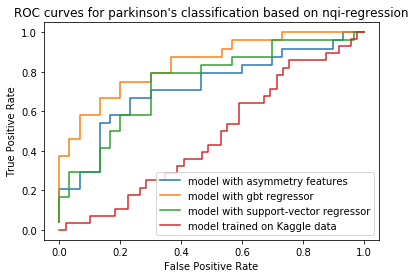

In [186]:
# Plot ROC curves for all of the above variations on the model:
plot_multiple_roc_curves([('model with asymmetry features', nqi_regression_on_mit_data_with_assymetry_features.y_true,
                           nqi_regression_on_mit_data_with_assymetry_features.y_predicted),                          
                          ('model with gbt regressor', nqi_regression_on_mit_data_with_gbt_regression_results.y_true,
                           nqi_regression_on_mit_data_with_gbt_regression_results.y_predicted),                          
                          ('model with support-vector regressor', nqi_regression_on_mit_data_with_sv_regression_results.y_true,
                           nqi_regression_on_mit_data_with_sv_regression_results.y_predicted),                          
                          ('model trained on Kaggle data', nqi_regression_on_kaggle_and_mit_data_with_gbt_regression_results.y_true,
                           nqi_regression_on_kaggle_and_mit_data_with_gbt_regression_results.y_predicted),                          
                          ], 
                         title="ROC curves for parkinson's classification based on nqi-regression")

We now make an attempt to use the features that were constructed for the UPDRS-regression to directly classify a patient as Parkinson's positive\negative. This is desired because in the first dataset we do not have UPDRS scores so we cannot train the above model that performed well on the MIT dataset. 

In [187]:
kaggle_ids = kaggle_data.ID.unique()


NFOLDS = 10
cv_gen = KFold(NFOLDS, shuffle=True)

clf = GradientBoostingClassifier()
final_probabilities_over_folds = pd.DataFrame()

i = 1
for train_indices, test_indices in cv_gen.split(kaggle_ids):
    print("Fitting & testing fold #{}".format(i))
    train_ids = kaggle_ids[train_indices]
    test_ids = kaggle_ids[test_indices]
    train_data = kaggle_data[kaggle_data.ID.isin(train_ids)].copy()
    test_data = kaggle_data[kaggle_data.ID.isin(test_ids)].copy()
    clf.fit(train_data[PREDICTION_COLUMNS], train_data["Parkinsons"])
    test_data["predicted_pd_prob"] = clf.predict_proba(X=test_data[PREDICTION_COLUMNS])[:,1]
    
    # average probabilities over time-windows per-subject:
    final_probabilities_over_folds = pd.concat([final_probabilities_over_folds, test_data.groupby("ID")["predicted_pd_prob", "Parkinsons"].mean()])
    i += 1
print("\nsample of final predictions:\n", final_probabilities_over_folds.head())

Fitting & testing fold #1


Fitting & testing fold #2


Fitting & testing fold #3


Fitting & testing fold #4


Fitting & testing fold #5


Fitting & testing fold #6


Fitting & testing fold #7


Fitting & testing fold #8


Fitting & testing fold #9


Fitting & testing fold #10



sample of final predictions:
             predicted_pd_prob  Parkinsons
ID                                       
1HOEBIGASW           0.318157       False
6LB9FQABZQ           0.290530       False
F56FSV2EP7           0.278536       False
TL2XHTLK1T           0.404462        True
VSBEPFSFWK           0.442226        True


In [188]:
test_auc = roc_auc_score(y_true=final_probabilities_over_folds['Parkinsons'], 
                    y_score=final_probabilities_over_folds['predicted_pd_prob'])
print(test_auc)

0.5553935860058309


We see that this approach is not much better than random, although it could have potential given a data set of higher quality and larger size.